In [5]:
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from einops import rearrange
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import copy
import math
import os, json
from typing import List,Tuple,Dict
from torch.nn.utils import prune

from turbpred.data_transformations import Transforms
from turbpred.model_diffusion_blocks import Unet, ConvNextBlock
from turbpred.model import PredictionModel
from turbpred.turbulence_dataset import TurbulenceDataset
from turbpred.params import DataParams, TrainingParams, LossParams, ModelParamsEncoder, ModelParamsDecoder, ModelParamsLatent
from turbpred.loss import PredictionLoss
from turbpred.loss_history import LossHistory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
modelName = "2D_Inc/128_unet-m2"
p_d = DataParams(batch=32, augmentations=["normalize"], sequenceLength=[2,2], randSeqOffset=True,
            dataSize=[104,52], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")
# p_d = DataParams(batch=32, augmentations=["normalize"], sequenceLength=[2,2], randSeqOffset=True,
#             dataSize=[128,64], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")

p_t = TrainingParams(epochs=1000, lr=0.0001)
p_l = LossParams(recMSE=0.0, predMSE=1.0)
p_me = None
p_ml = None

p_md2 = ModelParamsDecoder(arch="unet", pretrained=False, trainingNoise=0.0, convnext_mult=1)
# pretrainPath = "../runs/2D_Inc/128_unet-m2_17/Model.pth"
base_model = PredictionModel(p_d, p_t, p_l, p_me, p_md2, p_ml, "")


In [7]:
testSets = {
    "lowRey":
        TurbulenceDataset("Test Low Reynolds 100-200", ["../data"], filterTop=["128_inc"], filterSim=[[82,84,86,88,90]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
    "highRey" :
        TurbulenceDataset("Test High Reynolds 900-1000", ["../data"], filterTop=["128_inc"], filterSim=[[0,2,4,6,8]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
}

# Sparcity

In [9]:
def evaluate_sparcity(model):
    total_params = 0
    total_zeros = 0

    for name, module in model.named_modules():
        if hasattr(module, "weight"):
            num_params = sum(p.numel() for p in module.parameters())
            total_params += num_params
            total_zeros += torch.sum(module.weight == 0)

    return total_params, total_zeros.item()


In [10]:
def _prune(model:PredictionModel, prune_type:str, pruning_percentage:float):
    """ Prune Unet model """

    unet = model.modelDecoder
    conv_next_modules = [module for module in unet.modules() if type(module) is ConvNextBlock]
    
    if prune_type == 'L1':
        norm_n = 1
    elif prune_type == 'L2':
        norm_n = 2
    else:
        raise Exception("Wrong prune_type")

    for module in conv_next_modules:
        # We prune modules of ConvNextBlock that are scaled by convnext_mult 
        # module.net[1] --> Conv2D
        # module.net[3] --> GroupNorm
        # module.net[4] --> Conv2D
        
        prune.ln_structured(module.net[1], 'weight', amount=pruning_percentage, dim=0, n=norm_n)
        # prune.ln_structured(module.net[3], 'weight', amount=pruning_percentage, dim=1, n=norm_n)
        prune.ln_structured(module.net[4], 'weight', amount=pruning_percentage, dim=1, n=norm_n)


def prune_remove(model):
    unet = model.modelDecoder
    for name, module in unet.named_modules():
        if type(module) is ConvNextBlock:
            # print(name)
            prune.remove(module.net[1], 'weight')
            prune.remove(module.net[4], 'weight')

In [8]:
p_md = ModelParamsDecoder(arch="unet", pretrained=False, trainingNoise=0.0, convnext_mult=4)
pruned_pretrainPath = "../runs/2D_Inc/128_unet-m2_102/Model.pth"
pruned_model = PredictionModel(p_d, p_t, p_l, p_me, p_md, p_ml, pruned_pretrainPath)

In [56]:
total_params, spar = evaluate_sparcity(base_model)
print(f"Base model, {total_params} params, sparcity: {spar}")

total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {(spar/total_params):.2f}%, non-zero:{total_params-spar}")

Base model, 3856096 params, sparcity: 0
Pruned model, 11944072 params, sparcity: 0.00%, non-zero:11944072


In [57]:
total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {spar/total_params:.2f}")

for i in range(14):
    _prune(pruned_model, "L2", 0.1)
prune_remove(pruned_model)

total_params, spar = evaluate_sparcity(pruned_model)
print(f"Pruned model, {total_params} params, sparcity: {(spar/total_params):.2f}, non-zeros: {total_params - spar}")

Pruned model, 11944072 params, sparcity: 0.00
Pruned model, 11944072 params, sparcity: 0.70, non-zeros: 3635308


In [21]:
mods = [x for x in pruned_model.modelDecoder.modules() if type(x) is ConvNextBlock]

weights = [w for n, w in mods[0].net[4].named_parameters() if n == "weight"][0]
# print(weights.shape)

In [88]:
loadedPretrainedWeightDict = torch.load(pruned_pretrainPath)
pruned_model.modelDecoder.load_state_dict(loadedPretrainedWeightDict["stateDictDecoder"])

evaluate_sparcity(pruned_model)

(13888056, 5675904)

In [17]:
for name, p in pruned_model.named_parameters():
    print(name, type(p).__name__)

modelDecoder.init_conv.weight Parameter
modelDecoder.init_conv.bias Parameter
modelDecoder.downs.0.0.ds_conv.weight Parameter
modelDecoder.downs.0.0.ds_conv.bias Parameter
modelDecoder.downs.0.0.net.0.weight Parameter
modelDecoder.downs.0.0.net.0.bias Parameter
modelDecoder.downs.0.0.net.1.weight Parameter
modelDecoder.downs.0.0.net.1.bias Parameter
modelDecoder.downs.0.0.net.3.weight Parameter
modelDecoder.downs.0.0.net.3.bias Parameter
modelDecoder.downs.0.0.net.4.weight Parameter
modelDecoder.downs.0.0.net.4.bias Parameter
modelDecoder.downs.0.0.res_conv.weight Parameter
modelDecoder.downs.0.0.res_conv.bias Parameter
modelDecoder.downs.0.1.ds_conv.weight Parameter
modelDecoder.downs.0.1.ds_conv.bias Parameter
modelDecoder.downs.0.1.net.0.weight Parameter
modelDecoder.downs.0.1.net.0.bias Parameter
modelDecoder.downs.0.1.net.1.weight Parameter
modelDecoder.downs.0.1.net.1.bias Parameter
modelDecoder.downs.0.1.net.3.weight Parameter
modelDecoder.downs.0.1.net.3.bias Parameter
modelDec

In [45]:
prune_remove(pruned_model)

downs.0.0
downs.0.1
downs.1.0
downs.1.1
downs.2.0
downs.2.1
ups.0.0
ups.0.1
ups.1.0
ups.1.1
mid_block1
mid_block2
final_conv.0


In [18]:
nparams, nzeros = evaluate_sparcity(pruned_model)
nparams, nzeros, nparams - nzeros

(13888056, 5675904, 8212152)

In [52]:
evaluate_sparcity(base_model)


(5721912, 0)

In [4]:
p_d = DataParams(batch=32, augmentations=["normalize", "resize"], sequenceLength=[2,2], randSeqOffset=True,
            dataSize=[64,32], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")



In [8]:
# base_model.modelDecoder.
inChannels = (p_d.dimension + len(p_d.simFields) + len(p_d.simParams))
outChannels = p_d.dimension + len(p_d.simFields) + len(p_d.simParams)
inChannels, outChannels 

(4, 4)

In [9]:
model_prova = Unet(dim=64, out_dim=outChannels, channels=inChannels, dim_mults=(1,1,1), use_convnext=True, convnext_mult=1, with_time_emb=False)

In [10]:
evaluate_sparcity(model_prova)

(1560222, 1)

In [19]:
model_prova

Unet(
  (init_conv): Conv2d(4, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (ds_conv): Conv2d(42, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=42)
        (net): Sequential(
          (0): GroupNorm(1, 42, eps=1e-05, affine=True)
          (1): Conv2d(42, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d(42, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ConvNextBlock(
        (ds_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
        (net): Sequential(
          (0): GroupNorm(1, 64, eps=1e-05, affine=True)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='

In [ ]:
for name, p in model_prova.named_parameters():
    print(name, type(p).__name__)

    plt.hist(p.detach().flatten())
    plt.show()

# Testing

In [29]:
p_d = DataParams(batch=32, augmentations=["normalize"], sequenceLength=[2,2], randSeqOffset=True,
            dataSize=[104,52], dimension=2, simFields=["pres"], simParams=["rey"], normalizeMode="incMixed")
p_t = TrainingParams(epochs=1000, lr=0.0001)
p_l = LossParams(recMSE=0.0, predMSE=1.0)
p_me = None
p_ml = None
p_md = ModelParamsDecoder(arch="unet", pretrained=True, trainingNoise=0.0, convnext_mult=4)
pruned_pretrainPath = "../runs/2D_Inc/128_unet-m2_101/Model.pth"
pruned_model = PredictionModel(p_d, p_t, p_l, p_me, p_md, p_ml, pruned_pretrainPath)

In [30]:
data_folder = "../data"

testSets = {
    "lowRey":
        TurbulenceDataset("Test Low Reynolds 100-200", [data_folder], filterTop=["128_inc"], filterSim=[[82,84,86,88,90]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
    "highRey" :
        TurbulenceDataset("Test High Reynolds 900-1000", [data_folder], filterTop=["128_inc"], filterSim=[[0,2,4,6,8]],
                filterFrame=[(1000,1150)], sequenceLength=[[60,2]], simFields=p_d.simFields, simParams=p_d.simParams, printLevel="sim"),
}

In [54]:
testers = []
testHistories = []

criterion = PredictionLoss(p_l, p_d.dimension, p_d.simFields, useGPU=True)

testSet = testSets["highRey"]

p_d_test = copy.deepcopy(p_d)
p_d_test.augmentations = ["normalize"]
p_d_test.sequenceLength = testSet.sequenceLength
p_d_test.randSeqOffset = False
if p_d.sequenceLength[0] != p_d_test.sequenceLength[0]:
    p_d_test.batch = 1

transTest = Transforms(p_d_test)
testSet.transform = transTest
testSampler = SequentialSampler(testSet)
testLoader = DataLoader(testSet, sampler=testSampler,
                batch_size=p_d_test.batch, drop_last=False, num_workers=4)

avg_mse = torch.zeros(60)
avg_lsim = torch.zeros(60)

models_42_pruned = [85,86,103,104,105,106,107,108]
models_70_pruned = [89,90,97,98,99,100,101,102] 
models_ref = [83,84,91,92,93,94,95,96]

for model_id in models_ref:
    print("Evaluating model", model_id)
    p_md = ModelParamsDecoder(arch="unet", pretrained=True, trainingNoise=0.0, convnext_mult=1)
    pruned_pretrainPath = f"../runs/2D_Inc/128_unet-m2_{model_id}/Model.pth"
    pruned_model = PredictionModel(p_d, p_t, p_l, p_me, p_md, p_ml, pruned_pretrainPath)

    model_mse = torch.zeros(60)
    model_lsim = torch.zeros(60)
    pruned_model.eval()

    with torch.no_grad():
        for s, sample in enumerate(testLoader, 0):
            device = "cuda"
            data = sample["data"].to(device)
            simParameters = sample["simParameters"].to(device) if type(sample["simParameters"]) is not dict else None
            if "obsMask" in sample is not None:
                obsMask = sample["obsMask"].to(device)
                obsMask = torch.unsqueeze(torch.unsqueeze(obsMask, 1), 2)
            else:
                obsMask = None

            prediction, latentSpace, vaeMeanVar = pruned_model(data, simParameters, useLatent=True)

            if obsMask is not None:
                prediction = prediction * obsMask
                data       = data * obsMask

            _, lossParts, lossSeq = criterion(prediction, data, latentSpace, vaeMeanVar, weighted=False, noLSIM=p_t.noLSIM)

            print("Full loss:", lossParts["lossFull"].item())
            model_mse += lossSeq["MSE"].cpu() 
            model_lsim += lossSeq["LSIM"].cpu() 

    avg_mse += model_mse / len(testLoader)
    avg_lsim += model_lsim / len(testLoader)


Loading model from src/lsim/models/LSiM.pth
Loading model from ../src/lsim/models/LSiM.pth
Evaluating model 83


Full loss: 0.9343099594116211
Full loss: 0.9344780445098877
Full loss: 0.929153561592102
Full loss: 0.9221985340118408
Full loss: 0.9004448652267456
Evaluating model 84
Full loss: 0.8880237936973572
Full loss: 0.8820787668228149
Full loss: 0.8748866319656372
Full loss: 0.8652160167694092
Full loss: 0.8579360842704773
Evaluating model 91
Full loss: 0.9542229771614075
Full loss: 0.9480626583099365
Full loss: 0.9407094717025757
Full loss: 0.9309440851211548
Full loss: 0.9181463718414307
Evaluating model 92
Full loss: 0.988497257232666
Full loss: 0.9955927729606628
Full loss: 0.9934762716293335
Full loss: 0.9870315790176392
Full loss: 0.9756869077682495
Evaluating model 93
Full loss: 1.260959506034851
Full loss: 1.3268840312957764
Full loss: 1.3342924118041992
Full loss: 1.3149387836456299
Full loss: 1.2852391004562378
Evaluating model 94
Full loss: 0.9740149974822998
Full loss: 0.9670923948287964
Full loss: 0.9610546827316284
Full loss: 0.9517202377319336
Full loss: 0.9436724185943604
Eva

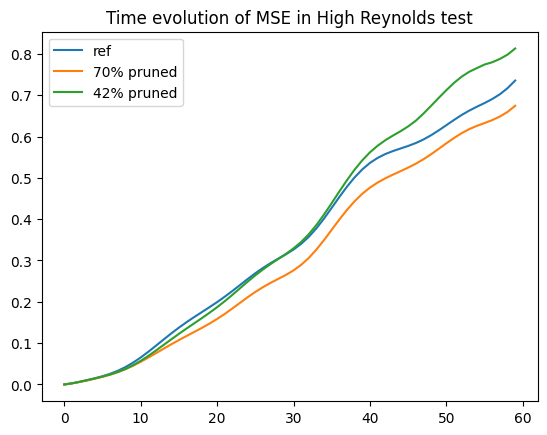

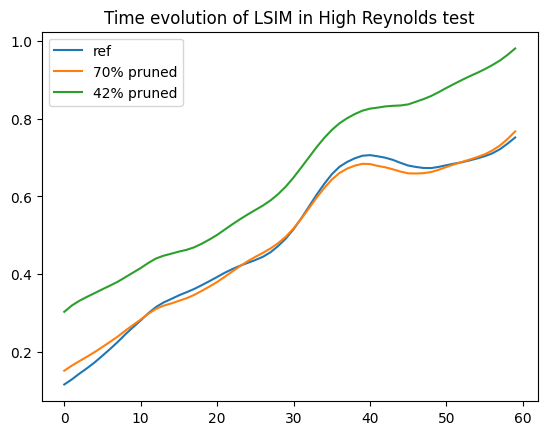

In [56]:
# avg_mse_70  = avg_mse / len(models_70_pruned)
# avg_lsim_70 = avg_lsim / len(models_70_pruned)

avg_mse_ref  = avg_mse / len(models_ref)
avg_lsim_ref = avg_lsim / len(models_ref)

# avg_mse_42  = avg_mse / len(models_42_pruned)
# avg_lsim_42 = avg_lsim / len(models_42_pruned)

plt.title("Time evolution of MSE in High Reynolds test")
plt.plot(avg_mse_ref, label="ref")
plt.plot(avg_mse_70, label="70% pruned")
plt.plot(avg_mse_42, label="42% pruned")
plt.legend()
plt.show()

plt.title("Time evolution of LSIM in High Reynolds test")
plt.plot(avg_lsim_ref, label="ref")
plt.plot(avg_lsim_70, label="70% pruned")
plt.plot(avg_lsim_42, label="42% pruned")
plt.legend()
plt.show()
